Выводы по анализу:

1. Предобработка данных:
- Период: 2507 торговых дней (≈10 лет при 250 торговых дней в году)
- Объем: 137.2+ KB
- Тип данных: Ежедневные итоги торгов по акциям
- В данных нет пропусков.
- Неправильные типы данных у даты, и у open, high, low, close (вместо float - obj).
- Период данных: с 2014-06-16 00:00:00 по 2024-06-14 00:00:00

2. Анализ целевой переменной:
- Классы сбалансированы (51.3% vs 48.7%)
- Коэффициент дисбаланса: 1.05 (незначительный)

3. 1. Распределние по признакам:
| Признак      | Диапазон     | Target 0 преобладает               | Target 1 преобладает          | Разделяющая сила |
|--------------|--------------|------------------------------------|-------------------------------|------------------|
| **close**    | 2000-8000    | Низкие значения (2000-4000)        | Высокие значения (5000-8000)  | Высокая          |
| **vol**      | Не указан    | Низкие и экстремально высокие значения | Средние значения              | Средняя          |
| **price_range** | 500-2500  | Низкие диапазоны (500-1500)        | Высокие диапазоны (1500-2500) | Очень высокая    |
| **volatility** | 0.0-0.4    | Низкие значения (0.0-0.15)         | Высокие значения (0.2-0.4)    | Очень высокая    |

- Наиболее значимые признаки - price_range и volatility демонстрируют очень высокую разделяющую способность с явными пороговыми значениями (≈1500 и ≈0.15-0.20 соответственно).

- Признак close также показывает высокую дифференцирующую способность - низкие цены ассоциированы с классом 0, высокие = с классом 1.

- Признак vol обладает средней разделяющей силой, что указывает на его потенциальную полезность в комбинации с другими признаками.

- 3.2. Рыночные характеристики
- Тренд: Явный восходящий тренд (от ~1900 до ~8100)
- Волатильность: Высокая (std ≈ 1600 относительно mean ≈ 4500)
- Ликвидность: Объемы показывают кластеризацию - типично для финансовых данных


- 3.3. Технические индикаторы
- Скользящие средние: Все близки к текущей цене, что ожидаемо
- RSI: Среднее 53.16 = рынок в нейтральной зоне в среднем
- Лаги: Минимальные отличия от текущих значений

4. Временные паттерны
Равномерность: Данные равномерно распределены по дням и месяцам

Покрытие: Полное десятилетие данных

4. Данные по корреляции:
- Все корреляции чрезвычайно слабые - значения находятся в диапазоне от -0.03 до +0.037
- Практически отсутствует линейная связь между признаками и целевой переменной
- Наибольшая положительная корреляция у признака vol (0.0367)
- Наибольшая отрицательная корреляция у признака low (-0.0307)

Ценовые признаки (open, high, low, close) демонстрируют схожие значения корреляции около -0.03

5. Моделирование:
| Модель                                         |              Accuracy              |            F1-score            |             ROC-AUC            |               MCC              |                         Confusion Matrix                        |
| :--------------------------------------------- | :--------------------------------: | :----------------------------: | :----------------------------: | :----------------------------: | :-------------------------------------------------------------: |
| **Logistic Regression (базовая)**              |             **0.4910**             |             0.4720             |             0.4957             |             -0.0192            |                     [[132, 125], [130, 114]]                    |
| **CatBoost (базовая)**                         |             **0.5469**             |             0.4989             |             0.5347             |             0.0908             |                     [[161, 96], [131, 113]]                     |
| **CatBoost с регуляризацией + early stopping** | **0.5208 (test)** / 0.6156 (train) | 0.4417 (test) / 0.6904 (train) | 0.5165 (test) / 0.6727 (train) | 0.0398 (test) / 0.2404 (train) | test: [[159, 84], [146, 91]]<br>train: [[359, 566], [172, 823]] |


1. Logistic Regression (базовая)
- Результаты: Все метрики близки к случайному угадыванию (0.5)
- MCC = -0.0192: Отрицательное значение указывает на худшее чем случайное предсказание
- Вывод: Линейная модель не способна уловить сложные зависимости в данных

2. CatBoost (базовая)
- Улучшение: Все метрики лучше линейной модели
- Accuracy = 0.5469: На 9% лучше случайного угадывания
- MCC = 0.0908: Положительное значение, но очень слабое
- Преимущество: Справляется с нелинейностями лучше линейных моделей

3. CatBoost с регуляризацией + early stopping
Переобучение:
- Train Accuracy: 0.6156 vs Test Accuracy: 0.5208 (разница 9.5%)
- Train F1: 0.6904 vs Test F1: 0.4417 (разница 24.9%)
Проблема: Модель запоминает обучающие данные, но плохо обобщает

ЧТо бы сделала в дальнейшем:
- Усиление регуляризации для CatBoost
- Кросс-валидация вместо единого разбиения
- Feature selection для удаления шумовых признаков
- Создание новых признаков на основе комбинаций существующих
- Ансамбли моделей
- Temporal Convolutional Networks (TCN), FT-Transformer



In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix


In [ ]:
# загрузка данных
data = pd.read_csv('table1.csv', sep=';')
print("Первые 5 строк:")
print(data.head())
print("\nИнформация о данных:")
print(data.info())
print("\nСтатистики:")
print(data.describe())

Первые 5 строк:
       date    open    high     low   close      vol  target
0  20140616  2092,2  2153,3  2067,3    2149  3720757       0
1  20140617  2205,1  2205,1  2122,5    2130  1494451       0
2  20140618    2135  2152,3  2121,8  2126,9  1129635       0
3  20140619    2140  2147,9    2112  2112,1  1140105       0
4  20140620    2119  2127,3  2086,1    2100  1067446       0

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2507 non-null   int64 
 1   open    2507 non-null   object
 2   high    2507 non-null   object
 3   low     2507 non-null   object
 4   close   2507 non-null   object
 5   vol     2507 non-null   int64 
 6   target  2507 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 137.2+ KB
None

Статистики:
               date           vol       target
count  2.507000e+03  2.507000e+03  2507.000000
me

In [ ]:
# пропуски
print("Пропуски в данных:")
print(data.isnull().sum())

Пропуски в данных:
date      0
open      0
high      0
low       0
close     0
vol       0
target    0
dtype: int64


In [ ]:
#работа с датой
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

print("Данные после правильного преобразования даты:")
print(data.head())
print("\nИнформация о датах:")
print(f"Период данных: с {data['date'].min()} по {data['date'].max()}")
print(f"Уникальные дни недели: {sorted(data['day_of_week'].unique())}")
print(f"Уникальные месяцы: {sorted(data['month'].unique())}")
print(f"Уникальные года: {sorted(data['year'].unique())}")

Данные после правильного преобразования даты:
        date    open    high     low   close      vol  target  day_of_week  \
0 2014-06-16  2092,2  2153,3  2067,3    2149  3720757       0            0   
1 2014-06-17  2205,1  2205,1  2122,5    2130  1494451       0            1   
2 2014-06-18    2135  2152,3  2121,8  2126,9  1129635       0            2   
3 2014-06-19    2140  2147,9    2112  2112,1  1140105       0            3   
4 2014-06-20    2119  2127,3  2086,1    2100  1067446       0            4   

   month  year  
0      6  2014  
1      6  2014  
2      6  2014  
3      6  2014  
4      6  2014  

Информация о датах:
Период данных: с 2014-06-16 00:00:00 по 2024-06-14 00:00:00
Уникальные дни недели: [0, 1, 2, 3, 4, 5]
Уникальные месяцы: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Уникальные года: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [ ]:
# исправления - числовые колонки
numeric_columns = ['open', 'high', 'low', 'close', 'vol']

for col in numeric_columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str).str.replace(',', '.').astype(float)

print("\nДанные после исправления числовых форматов:")
print(data.head())
print("\nТипы данных:")
print(data.dtypes)


Данные после исправления числовых форматов:
        date    open    high     low   close      vol  target  day_of_week  \
0 2014-06-16  2092.2  2153.3  2067.3  2149.0  3720757       0            0   
1 2014-06-17  2205.1  2205.1  2122.5  2130.0  1494451       0            1   
2 2014-06-18  2135.0  2152.3  2121.8  2126.9  1129635       0            2   
3 2014-06-19  2140.0  2147.9  2112.0  2112.1  1140105       0            3   
4 2014-06-20  2119.0  2127.3  2086.1  2100.0  1067446       0            4   

   month  year  
0      6  2014  
1      6  2014  
2      6  2014  
3      6  2014  
4      6  2014  

Типы данных:
date           datetime64[ns]
open                  float64
high                  float64
low                   float64
close                 float64
vol                     int64
target                  int64
day_of_week             int32
month                   int32
year                    int32
dtype: object


In [ ]:
# создание признаков
data['price_range'] = data['high'] - data['low']
data['price_change'] = data['close'] - data['open']
data['volatility'] = data['price_range'] / data['open']
data['typical_price'] = (data['high'] + data['low'] + data['close']) / 3

# процентные
data['pct_change'] = data['close'].pct_change()
data['vol_pct_change'] = data['vol'].pct_change()

# сдвинутые значения для лаговых признаков
for lag in [1, 2, 3]:
    data[f'close_lag_{lag}'] = data['close'].shift(lag)
    data[f'vol_lag_{lag}'] = data['vol'].shift(lag)

print("\nДанные с техническими индикаторами:")
print(data[['open', 'high', 'low', 'close', 'vol', 'price_range', 'price_change', 'volatility', 'pct_change']].head(5))


Данные с техническими индикаторами:
     open    high     low   close      vol  price_range  price_change  \
0  2092.2  2153.3  2067.3  2149.0  3720757         86.0          56.8   
1  2205.1  2205.1  2122.5  2130.0  1494451         82.6         -75.1   
2  2135.0  2152.3  2121.8  2126.9  1129635         30.5          -8.1   
3  2140.0  2147.9  2112.0  2112.1  1140105         35.9         -27.9   
4  2119.0  2127.3  2086.1  2100.0  1067446         41.2         -19.0   

   volatility  pct_change  
0    0.041105         NaN  
1    0.037459   -0.008841  
2    0.014286   -0.001455  
3    0.016776   -0.006958  
4    0.019443   -0.005729  


In [ ]:
print("\nСтатистики:")
print(data.describe())

Распределение целевой переменной:
target
1    1286
0    1221
Name: count, dtype: int64

Процентное распределение:
target
1    51.29637
0    48.70363
Name: count, dtype: float64


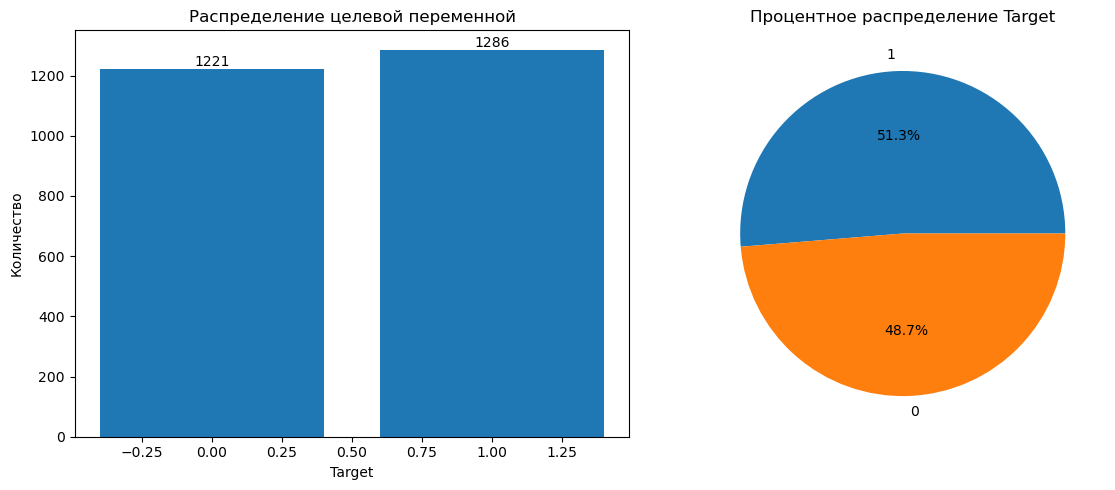


Коэффициент дисбаланса: 1.05


In [ ]:
#  баланс классов
print("Распределение целевой переменной:")
target_distribution = data['target'].value_counts()
print(target_distribution)


print("\nПроцентное распределение:")
print(target_distribution / len(data) * 100)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(target_distribution.index, target_distribution.values)
plt.title('Распределение целевой переменной')
plt.xlabel('Target')
plt.ylabel('Количество')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

#  диаграмма
plt.subplot(1, 2, 2)
plt.pie(target_distribution.values, labels=target_distribution.index, autopct='%1.1f%%')
plt.title('Процентное распределение Target')

plt.tight_layout()
plt.show()

# анализ дисбаланса
imbalance_ratio = target_distribution.max() / target_distribution.min()
print(f"\nКоэффициент дисбаланса: {imbalance_ratio:.2f}")

Средние значения по классам:

open:
  Target 0: 4509.88
  Target 1: 4413.11

high:
  Target 0: 4560.98
  Target 1: 4463.66

low:
  Target 0: 4455.12
  Target 1: 4357.60

close:
  Target 0: 4511.19
  Target 1: 4414.54

vol:
  Target 0: 947742.51
  Target 1: 996172.92

price_range:
  Target 0: 105.85
  Target 1: 106.07

volatility:
  Target 0: 0.02
  Target 1: 0.02


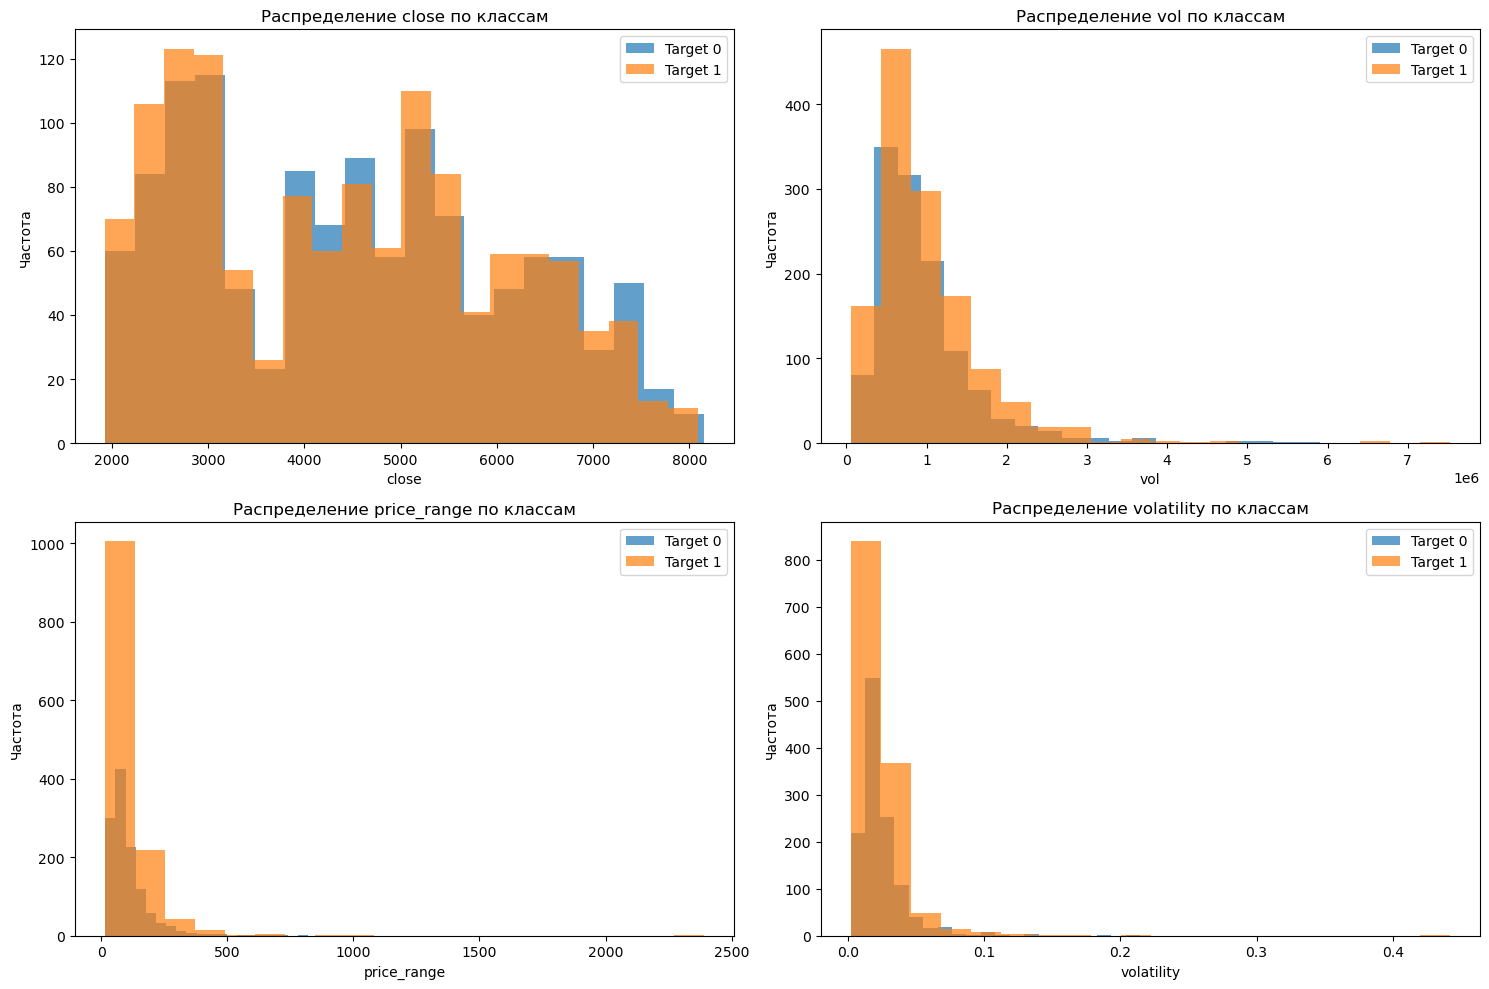

In [ ]:
# взаимосвязи целевой переменной с другими признаками
print("Средние значения по классам:")
numeric_features = ['open', 'high', 'low', 'close', 'vol', 'price_range', 'volatility']
for feature in numeric_features:
    if feature in data.columns:
        means = data.groupby('target')[feature].mean()
        print(f"\n{feature}:")
        for target_val, mean_val in means.items():
            print(f"  Target {target_val}: {mean_val:.2f}")

#  распределение ключевых признаков по классам
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

key_features = ['close', 'vol', 'price_range', 'volatility'][:4]
for i, feature in enumerate(key_features):
    if feature in data.columns:
        for target_val in data['target'].unique():
            subset = data[data['target'] == target_val]
            axes[i].hist(subset[feature], alpha=0.7, label=f'Target {target_val}', bins=20)
        axes[i].set_title(f'Распределение {feature} по классам')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Частота')
        axes[i].legend()

plt.tight_layout()
plt.show()

Корреляции с целевой переменной:
target_numeric    1.000000
vol               0.036687
volatility        0.006955
price_range       0.001113
high             -0.030129
close            -0.030169
open             -0.030203
low              -0.030747
Name: target_numeric, dtype: float64


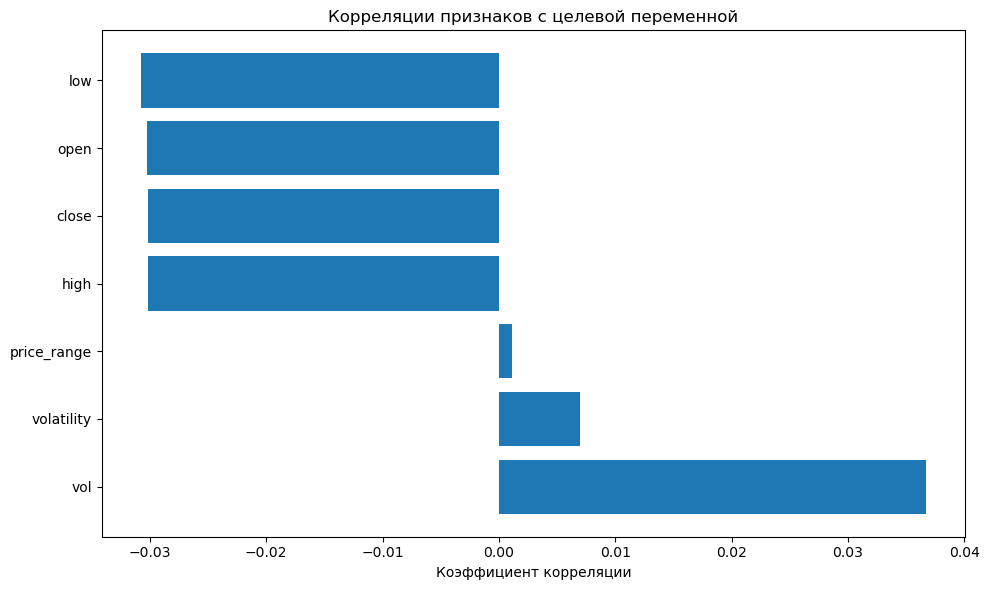

In [ ]:
# корреляция целевой переменной с другими признаками
if 'target' in data.columns:
    correlation_data = data.copy()
    correlation_data['target_numeric'] = correlation_data['target'].astype(int)
    correlations = correlation_data[numeric_features + ['target_numeric']].corr()['target_numeric'].sort_values(ascending=False)
    print("Корреляции с целевой переменной:")
    print(correlations)

    # визуализация корреляций
    plt.figure(figsize=(10, 6))
    correlations_without_self = correlations.drop('target_numeric', errors='ignore')
    plt.barh(range(len(correlations_without_self)), correlations_without_self.values)
    plt.yticks(range(len(correlations_without_self)), correlations_without_self.index)
    plt.title('Корреляции признаков с целевой переменной')
    plt.xlabel('Коэффициент корреляции')
    plt.tight_layout()
    plt.show()

## Моделирование

In [ ]:
# baseline модель

data = data.dropna().reset_index(drop=True)

# фичи (всё кроме целевой и даты)
features = [
    'open', 'high', 'low', 'close', 'vol',
    'day_of_week', 'month', 'year',
    'price_range', 'price_change', 'volatility',
    'typical_price', 'pct_change', 'vol_pct_change',
    'close_lag_1', 'vol_lag_1', 'close_lag_2', 'vol_lag_2', 'close_lag_3', 'vol_lag_3'
]

X = data[features]
y = data['target']

train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
mcc = matthews_corrcoef(y_test, y_pred)

print("Бейзлайн% Logistic Regression")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print(f"MCC:       {mcc:.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Бейзлайн% Logistic Regression
Accuracy:  0.4910
F1-score:  0.4720
ROC-AUC:   0.4957
MCC:       -0.0192

Confusion matrix:
[[132 125]
 [130 114]]


In [ ]:
# вторая модель
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=5,
    random_seed=42,
    verbose=0
)

model.fit(X_train_scaled, y_train)

#оценка
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
mcc = matthews_corrcoef(y_test, y_pred)

print("Модель 2 - catboost")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print(f"MCC:       {mcc:.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

Бейзлайн% catboost
Accuracy:  0.5469
F1-score:  0.4989
ROC-AUC:   0.5347
MCC:       0.0908

Confusion matrix:
[[161  96]
 [131 113]]


In [ ]:
# модель 3
# работа с признаками
data['price_range'] = data['high'] - data['low']
data['price_change'] = data['close'] - data['open']
data['volatility'] = data['price_range'] / data['open']
data['typical_price'] = (data['high'] + data['low'] + data['close']) / 3

data['sma_3'] = data['close'].rolling(3).mean()
data['sma_7'] = data['close'].rolling(7).mean()
data['ema_5'] = data['close'].ewm(span=5).mean()
data['ema_10'] = data['close'].ewm(span=10).mean()

# RSI
delta = data['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
data['rsi'] = 100 - (100 / (1 + rs))

# лаги
for lag in [1, 2, 3]:
    data[f'close_lag_{lag}'] = data['close'].shift(lag)
    data[f'vol_lag_{lag}'] = data['vol'].shift(lag)

data = data.dropna().reset_index(drop=True)


X = data.drop(columns=['target', 'date'])
y = data['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# добавляю регуляризацию от переобучения
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=10,
    subsample=0.8,
    random_seed=42,
    od_type='Iter',
    od_wait=50,
    verbose=100,
    loss_function='Logloss',
    eval_metric='AUC'
)

model.fit(
    X_train_scaled, y_train,
    eval_set=(X_test_scaled, y_test),
    early_stopping_rounds=50,
    use_best_model=True
)


y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]


def print_metrics(title, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n {title}")
    print("=" * 40)
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print(f"MCC:       {mcc:.4f}")
    print("Confusion matrix:")
    print(cm)


print_metrics("TRAIN METRICS", y_train, y_train_pred, y_train_proba)
print_metrics("TEST METRICS", y_test, y_test_pred, y_test_proba)


0:	test: 0.5135177	best: 0.5135177 (0)	total: 18ms	remaining: 36.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5165303606
bestIteration = 9

Shrink model to first 10 iterations.

 TRAIN METRICS
Accuracy:  0.6156
F1-score:  0.6904
ROC-AUC:   0.6727
MCC:       0.2404
Confusion matrix:
[[359 566]
 [172 823]]

 TEST METRICS
Accuracy:  0.5208
F1-score:  0.4417
ROC-AUC:   0.5165
MCC:       0.0398
Confusion matrix:
[[159  84]
 [146  91]]
